In [1]:
# Importing common packages

import os, sys, random
import csv, sklearn, matplotlib
import mlflow, logging
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, precision_recall_curve, auc, confusion_matrix
from urllib.parse import urlparse

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

## Assignment 1

Loading the test, val and test datasets

In [2]:
train_data = [i.split('\n')[0] for i in open("../data/train_data.csv").readlines()]
val_data = [i.split('\n')[0] for i in open("../data/val_data.csv").readlines()]
test_data = [i.split('\n')[0] for i in open("../data/test_data.csv").readlines()]

Separating label and list of words from the combined string

In [3]:
def get_string_from_list_words(word_list):
    temp = ""
    for i in word_list:
        temp = temp + i + " "

    return temp

x_train, y_train = [get_string_from_list_words(i.split(',')[1:]) for i in train_data], [i.split(',')[0] for i in train_data]
x_val, y_val = [get_string_from_list_words(i.split(',')[1:]) for i in val_data], [i.split(',')[0] for i in val_data]
x_test, y_test = [get_string_from_list_words(i.split(',')[1:]) for i in test_data], [i.split(',')[0] for i in test_data]

Converting the data to bag-of-words to be used in 3 models, viz. Multinomial Naive Bayes, Logistic Regression, Semi-supervised Clustering

Defining the Vectorizer

In [4]:
word_vec = CountVectorizer()
word_vec.fit(x_train)

CountVectorizer()

Creating a Bag-of-words corpus

In [5]:
train_vocab = word_vec.vocabulary_

x_train_vec = word_vec.transform(x_train)
x_val_vec = word_vec.transform(x_val)
x_test_vec = word_vec.transform(x_test)

len(train_vocab), x_train_vec.shape, x_val_vec.shape, x_test_vec.shape

(5944, (3901, 5944), (836, 5944), (837, 5944))

Converting Bag-of-Words corpus to tf-idf corpus

In [6]:
tfidf_transformer = TfidfTransformer().fit(x_train_vec)

x_train_tf = tfidf_transformer.transform(x_train_vec)
x_val_tf = tfidf_transformer.transform(x_val_vec)
x_test_tf = tfidf_transformer.transform(x_test_vec)

x_train_tf.shape, x_val_tf.shape, x_test_tf.shape

((3901, 5944), (836, 5944), (837, 5944))

Replacing labels by 0/1: Spam = 1; Ham = 0

In [7]:
def replace_labels(list1):
    temp_list = []
    for el in list1:
        if el == "ham":
            temp_list.append(0)
        else:
            temp_list.append(1)

    return temp_list

y_train = replace_labels(y_train)
y_val = replace_labels(y_val)
y_test = replace_labels(y_test)

### Model 1: Multinomial Naive Bayes

In [8]:
for i in np.arange(0.25, 2.25, 0.25):
    multi_nb_spam_model = MultinomialNB(alpha=i).fit(x_train_tf, y_train)
    y_pred = multi_nb_spam_model.predict(x_val_tf)
    print(i, "\n", classification_report(y_val, y_pred))

0.25 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99       719
           1       0.98      0.91      0.95       117

    accuracy                           0.99       836
   macro avg       0.98      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836

0.5 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       719
           1       0.99      0.87      0.93       117

    accuracy                           0.98       836
   macro avg       0.98      0.94      0.96       836
weighted avg       0.98      0.98      0.98       836

0.75 
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       719
           1       1.00      0.83      0.91       117

    accuracy                           0.98       836
   macro avg       0.99      0.91      0.95       836
weighted avg       0.98      0.98      0.98       836


#### Looking at the scores for each model with different alpha values, alpha = 0.25 gives the best results. 

In [9]:
multi_nb_spam_model = MultinomialNB(alpha=0.25).fit(x_train_tf, y_train)
y_test_pred = multi_nb_spam_model.predict(x_test_tf)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       714
           1       0.96      0.85      0.90       123

    accuracy                           0.97       837
   macro avg       0.97      0.92      0.94       837
weighted avg       0.97      0.97      0.97       837



### Model 2: Logistic Regression

Converting labels to 0 or 1

In [10]:
for i in [0.1, 0.5, 1, 10, 20, 50, 100]:
    log_reg_model = LogisticRegression(C = i)
    log_reg_model.fit(x_train_tf, y_train)
    y_pred = log_reg_model.predict(x_val_tf)
    print(i, "\n", classification_report(y_val, y_pred, zero_division=1))

0.1 
               precision    recall  f1-score   support

           0       0.86      1.00      0.92       719
           1       0.00      0.00      0.00       117

    accuracy                           0.86       836
   macro avg       0.43      0.50      0.46       836
weighted avg       0.74      0.86      0.79       836

0.5 
               precision    recall  f1-score   support

           0       0.93      1.00      0.96       719
           1       0.98      0.52      0.68       117

    accuracy                           0.93       836
   macro avg       0.96      0.76      0.82       836
weighted avg       0.94      0.93      0.92       836

1 
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       719
           1       0.99      0.75      0.85       117

    accuracy                           0.96       836
   macro avg       0.97      0.88      0.92       836
weighted avg       0.97      0.96      0.96       836

10 

C = 10 gives the best results

In [11]:
log_reg_model = LogisticRegression(C = 10)
log_reg_model.fit(x_train_tf, y_train)

y_test_pred = log_reg_model.predict(x_test_tf)
print(classification_report(y_val, y_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       719
           1       0.98      0.91      0.95       117

    accuracy                           0.99       836
   macro avg       0.98      0.96      0.97       836
weighted avg       0.99      0.99      0.99       836



### Model 3: Semi-Supervised Clustering

Defining a K-Means clustering model on the training data. Using the elbow method, we will select the best number of clusters. Then, using the labels of the centroid of the clusters, we will classify the datapoints. 

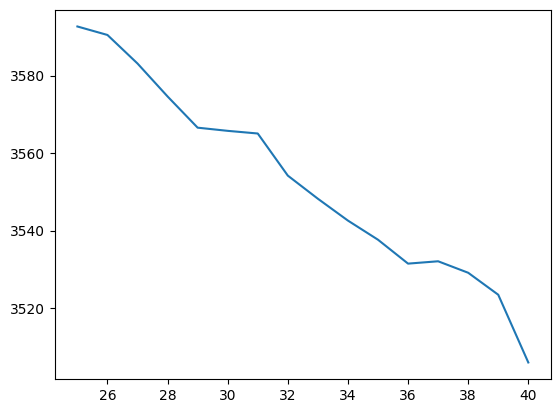

In [12]:
clusters_list = []
inertia_list = []
for i in range(25,41):
    cluster_model = KMeans(i).fit(x_train_tf)
    clusters_list.append(i)
    inertia_list.append(cluster_model.inertia_)

plt.plot(clusters_list, inertia_list)
plt.show()

Taking number of clusters as 37, we will now fit this model and transform the data to cluster data space. Also predict the labels for validation dataset

In [13]:
cluster_model = KMeans(37).fit(x_train_tf)
x_train_clus = cluster_model.transform(x_train_tf)
rep_class_idx = np.argmin(x_train_clus, axis=0)
x_rep_class = x_train_tf[rep_class_idx]
y_rep_class = np.array(y_train)[rep_class_idx]

val_clus_pred = cluster_model.predict(x_val_tf)
y_valid_pred = []
for i in val_clus_pred:
    y_valid_pred.append(y_rep_class[i])

print(classification_report(y_val, y_valid_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.86      1.00      0.93       719
           1       1.00      0.01      0.02       117

    accuracy                           0.86       836
   macro avg       0.93      0.50      0.47       836
weighted avg       0.88      0.86      0.80       836



Predicting for test dataset

In [14]:
test_clus_pred = cluster_model.predict(x_test_tf)
y_test_pred = []
for i in test_clus_pred:
    y_test_pred.append(y_rep_class[i])

print(classification_report(y_test, y_test_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       714
           1       1.00      0.00      0.00       123

    accuracy                           0.85       837
   macro avg       0.93      0.50      0.46       837
weighted avg       0.87      0.85      0.79       837



### Conclusion

The Logistic Regression model performed the best among all three and will be selected for further use on this dataset

## Assignment 2

### Defining bencmarking functions for all models

#### Model 1: Multinomial Naive Bayes

In [15]:
def mnb_model(x_train_tf, y_train, x_val_tf, y_val, a):
    multi_nb_spam_model = MultinomialNB(alpha = a).fit(x_train_tf, y_train)
    y_pred = multi_nb_spam_model.predict(x_val_tf)
    
    acc_score = accuracy_score(y_val, y_pred)
    
    # Computing Precision and Recall
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    aupcr = auc(recall, precision)

    conf_mat = confusion_matrix(y_val, y_pred)

    return [multi_nb_spam_model, acc_score, aupcr, conf_mat]

#### Model 2: Logistic Regression

In [16]:
def lr_model(x_train_tf, y_train, x_val_tf, y_val, c_value):
    log_reg_model = LogisticRegression(C = c_value, max_iter=10000)
    log_reg_model.fit(x_train_tf, y_train)
    y_pred = log_reg_model.predict(x_val_tf)
    
    acc_score = accuracy_score(y_val, y_pred)
    
    # Computing Precision and Recall
    precision, recall, thresholds = precision_recall_curve(y_val, y_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    aupcr = auc(recall, precision)

    conf_mat = confusion_matrix(y_val, y_pred)

    return [log_reg_model, acc_score, aupcr, conf_mat]

#### Model 3: Semi-Supervised Clustering

In [17]:
def kmeans_model(x_train_tf, y_train, x_val_tf, y_val, clusters):
    cluster_model = KMeans(clusters).fit(x_train_tf)
    x_train_clus = cluster_model.transform(x_train_tf)
    rep_class_idx = np.argmin(x_train_clus, axis=0)
    x_rep_class = x_train_tf[rep_class_idx]
    y_rep_class = np.array(y_train)[rep_class_idx]

    val_clus_pred = cluster_model.predict(x_val_tf)
    y_valid_pred = []
    for i in val_clus_pred:
        y_valid_pred.append(y_rep_class[i])
    
    acc_score = accuracy_score(y_val, y_valid_pred)
    
    # Computing Precision and Recall
    precision, recall, thresholds = precision_recall_curve(y_val, y_valid_pred)
    # Use AUC function to calculate the area under the curve of precision recall curve
    aupcr = auc(recall, precision)

    conf_mat = confusion_matrix(y_val, y_valid_pred)

    return [cluster_model, acc_score, aupcr, conf_mat]

### Running and Tracking Benchmarking experiments with MLFlow

Multinomial Niave Bayes

In [18]:
mlflow.sklearn.autolog()

md_name = "Multinomial Naive Bayes" 

for i in np.arange(0.05, 2.25, 0.25):
    with mlflow.start_run(run_name = f"Model : {md_name}, Alpha : {i}"):
        
        #Log parameters
        mlflow.log_param("Alpha",i)

        #Running the model
        model_metrics = mnb_model(x_train_tf, y_train, x_val_tf, y_val, i)

        #Logging metrics
        mlflow.log_metric("Accuracy", model_metrics[1])
        mlflow.log_metric("AUPCR", model_metrics[2])

        #Logging JSON of confusion matrix
        mlflow.log_dict(np.array(model_metrics[3]).tolist(), "confusion_matrix.json")
        mlflow.sklearn.log_model(model_metrics[0], "model")

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.sklearn.log_model(
            sk_model = model_metrics[0],
            artifact_path="sklearn-model",
            registered_model_name="Multinomial Naive Bayes"
        )
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model_metrics[0], "model", registered_model_name="Multinomial Naive Bayes")
        else:
          mlflow.sklearn.log_model(model_metrics[0], "model")

2023/03/14 01:07:09 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/home/rohan/anaconda3/envs/env_cmi_all/lib/python3.9/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils."
Successfully registered model 'Multinomial Naive Bayes'.
2023/03/14 01:07:12 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Multinomial Naive Bayes, version 1
Created version '1' of model 'Multinomial Naive Bayes'.
Registered model 'Multinomial Naive Bayes' already exists. Creating a new version of this model...
2023/03/14 01:07:17 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Multinomial Naive Bayes, version 2
Created version '2' of model 'Multinomial Naive Bayes'.
Registered model 'Multinomial Naive Bayes' already exists. Creating a new version of this

Logistic Regression

In [19]:
mlflow.sklearn.autolog()

md_name = "Logistic Regression"

for i in [0.1, 0.5, 1, 10, 20, 50, 100]:
    with mlflow.start_run(run_name = f"Model : {md_name}, C : {i}"):
        
        #Log parameters
        mlflow.log_param("C",i)

        #Running the model
        model_metrics = lr_model(x_train_tf, y_train, x_val_tf, y_val, i)

        #Logging metrics
        mlflow.log_metric("Accuracy", model_metrics[1])
        mlflow.log_metric("AUPCR", model_metrics[2])

        #Logging JSON of confusion matrix
        mlflow.log_dict(np.array(model_metrics[3]).tolist(), "confusion_matrix.json")
        mlflow.sklearn.log_model(model_metrics[0], "model")

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.sklearn.log_model(
            sk_model = model_metrics[0],
            artifact_path="sklearn-model",
            registered_model_name="Logistic Regression"
        )
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model_metrics[0], "model", registered_model_name = "Logistic Regression")
        else:
          mlflow.sklearn.log_model(model_metrics[0], "model")

Successfully registered model 'Logistic Regression'.
2023/03/14 01:07:58 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Logistic Regression, version 1
Created version '1' of model 'Logistic Regression'.
Registered model 'Logistic Regression' already exists. Creating a new version of this model...
2023/03/14 01:08:04 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Logistic Regression, version 2
Created version '2' of model 'Logistic Regression'.
Registered model 'Logistic Regression' already exists. Creating a new version of this model...
2023/03/14 01:08:09 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Logistic Regression, version 3
Created version '3' of model 'Logistic Regression'.
Registered model 'Logisti

Semi-Supervised Clustering

In [20]:
mlflow.sklearn.autolog()

md_name = "Semi-Supervised Clustering"

for i in range(25,41):
    with mlflow.start_run(run_name = f"Model : {md_name}, C : {i}"):
        
        #Log parameters
        mlflow.log_param("C",i)

        #Running the model
        model_metrics = kmeans_model(x_train_tf, y_train, x_val_tf, y_val, i)

        #Logging metrics
        mlflow.log_metric("Accuracy", model_metrics[1])
        mlflow.log_metric("AUPCR", model_metrics[2])

        #Logging JSON of confusion matrix
        mlflow.log_dict(np.array(model_metrics[3]).tolist(), "confusion_matrix.json")
        mlflow.sklearn.log_model(model_metrics[0], "model")

        tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme
        mlflow.sklearn.log_model(
            sk_model = model_metrics[0],
            artifact_path="sklearn-model",
            registered_model_name="Semi-Supervised Clustering"
        )
        if tracking_url_type_store != "file":
            mlflow.sklearn.log_model(model_metrics[0], "model", registered_model_name = "Semi-Supervised Clustering")
        else:
          mlflow.sklearn.log_model(model_metrics[0], "model")

2023/03/14 01:08:30 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
Successfully registered model 'Semi-Supervised Clustering'.
2023/03/14 01:08:34 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: Semi-Supervised Clustering, version 1
Created version '1' of model 'Semi-Supervised Clustering'.
2023/03/14 01:08:37 WARNING mlflow.sklearn: Training metrics will not be recorded because training labels were not specified. To automatically record training metrics, provide training labels as inputs to the model training function.
Registered model 'Semi-Supervised Clustering' already exists. Creating a new version of this model...
2023/03/14 01:08:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to 